# Luong Attention
## Attention score function comparison
In this notebook we will compares the performance of the dot, general, concat, and MLP score function
- In the [paper](https://arxiv.org/abs/1508.04025), Luong use 4 stacked layer LSTM as Encoder and Decoder. But we just use a single layer GRU for convenience.
- we train 15 epoch for every model.
- we keep the order of tokens in source sentent(no reverse).
- Our translate test sentence all come from the vaildation and test set.(not involved in the training)
- We trained two models for each method.
- we set our hyperparameter as fellow:
    - single layer GRU
    - (both encoder and decoder) GRUhidden dim: 512
    - (both source and target)Word embedding dim: 256
    - Attentional hidden dim same as GRU hidden dim: 512
    - Dropout rate = 0.15
    - teacher forcing ratio = 0.5

### Dot & General
we trained six models for dot method and four models for general method. 
- The general method performs worse than the dot method.
- We find that dot and general method few attend to things make sense such as word alignment, but the model translates the sentence correctly to some extent.
- In fact, it turns out that the dot and general method is unstable(compare to MLP). In experiments, things that each model attend to is very different and most of steps of models do not attend to things make sense.
- The attention weight is very **sharp**, especially in the general method , just like extracting a particular 'memory unit'.

### Concat
- The attention weight of the concat method is the exactly same. This is very strange just like a bug, but the performance of model looks OK. 

### MLP
- The model using the MLP method is very powerful and achieves the best performance. Also, the model is easily overfitting.
- In experiments, the model is stable. There is little difference in what the models attend to(almost alignment).

## Reverse the order of source sentence
We trained single layer RNN models using the the MLP method.
- As the paper says reversing the order of the source sentences does help a little with model performance.
- We achieves 31 BLEU score in test set

## Multi-layer RNN
We trained 2-layer, 3-layer RNN models using the MLP method. 
- More layers make the model converge more slowly, but the performance got a little worse

### 3-layer RNN
- In the three-layer RNN we trained 35 epochs to achieve similar performance to the other models

### Dot method

In [1]:
from dataset import Dataset

reverse_src = False
device = "cuda"
dataset = Dataset(reverse_src, device)

word_minq = 1
dataset.build_vocab(word_minq,word_minq)

src_vocab_size = len(dataset.srcField.vocab)
trg_vocab_size = len(dataset.trgField.vocab)
src_pad_idx = dataset.srcField.vocab.__getitem__(dataset.special_tokens['pad'])
trg_pad_idx = dataset.trgField.vocab.__getitem__(dataset.special_tokens['pad'])

In [2]:
from Luong.models import Seq2Seq

model = Seq2Seq(src_vocab_size,trg_vocab_size,src_pad_idx,trg_pad_idx).to(device)

print(model.parameters)
print("score function is ",model.decoder.attention.method)

/home/ljy/.conda/envs/long_NLP/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.15 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


<bound method Module.parameters of Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9796, 256, padding_idx=1)
    (rnn): GRU(256, 512, batch_first=True, dropout=0.15)
    (dropout): Dropout(p=0.15, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(18668, 256, padding_idx=1)
    (dropout): Dropout(p=0.15, inplace=False)
    (rnn): GRU(768, 512, batch_first=True, dropout=0.15)
    (attention): Luong_Attention()
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (out_fc): Linear(in_features=512, out_features=18668, bias=True)
  )
)>
score function is  dot


In [3]:
from Luong.trainer import train
import torch

clip = 5
lr = 1e-2
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# optimizer = torch.optim.SGD(model.parameters(), lr)
optimizer = torch.optim.Adam(model.parameters())

train(model, optimizer, clip, dataset, 
      num_epochs=15, mini_batch_size=128, accum_iter=1,
      print_every=100)

model.save("Luong_dot06_E15.pt")

batch_size: 128
-----------------------------------------------------------------
Epoch 1
-----------------------------------------------------------------
[ 100/227 ] Loss: 5.146389... Val Loss: 5.598367... Val BLEU: 1.896658...
[ 200/227 ] Loss: 5.500130... Val Loss: 5.425997... Val BLEU: 0.000000...
[ 227/227 ] Loss: 5.522206... Val Loss: 5.346288... Val BLEU: 1.857084...
Total Epoche:  |    Time: 0m 20s
 Epoch Loss: 5.179817... Train BLEU: 1.797679...
-----------------------------------------------------------------
Epoch 2
-----------------------------------------------------------------
[ 100/227 ] Loss: 4.288465... Val Loss: 5.148465... Val BLEU: 3.988388...
[ 200/227 ] Loss: 4.075806... Val Loss: 4.886986... Val BLEU: 6.880759...
[ 227/227 ] Loss: 4.738300... Val Loss: 4.831881... Val BLEU: 7.496719...
Total Epoche:  |    Time: 0m 23s
 Epoch Loss: 4.636793... Train BLEU: 6.888694...
-----------------------------------------------------------------
Epoch 3
----------------------

### Unstable
We load two models separately and translate the same sentence.
- things that two model attend to is very different.

In [4]:
# The chosen sentences for test

# src = "a large crowd of people are standing around in a park and a few are playing instruments ."
# trg = "eine große menschenmenge steht in einem park herum und einige spielen auf instrumenten ."

# src = "a female playing a song on her violin ."
# trg = "eine frau spielt ein lied auf ihrer geige ."

# src = "people standing outside of a building ."
# trg = "leute , die vor einem gebäude stehen ."

# src = "three young children stand around a blue and white barrel ."
# trg = "drei kleine kinder stehen um ein blau-weißes fass herum ."

# src = "a little girl is holding a little boy on her lap ."
# trg = "ein kleines mädchen hält einen kleinen jungen auf ihrem schoß ."

# src = "a group of people are climbing in cold weather ."
# trg = "eine gruppe klettert bei kaltem wetter ."

# src = "a boy in a red uniform is attempting to avoid getting out at home plate , while the catcher in the blue uniform is attempting to catch him ."
# trg = "ein junge in einem roten trikot versucht , die home base zu erreichen , während der catcher im blauen trikot versucht , ihn zu fangen ."

We load six models for comparison

In [4]:
from Luong.models import Seq2Seq

device = "cuda"

for i in range(1,7):
    exec(f"model{i} = Seq2Seq(src_vocab_size,trg_vocab_size,src_pad_idx,trg_pad_idx,build=False).to(device)")
    exec(f"model{i}.load('Luong_dot0{i}_E15.pt',device)")

/home/ljy/.conda/envs/long_NLP/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.15 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [5]:
batch_size = 128
train_iterator, val_iterator, test_iter = dataset.build_DataLoad(batch_size)

from Luong.validator import evaluate

pad_idx = dataset.srcField.vocab.__getitem__(dataset.special_tokens['pad'])
bos_idx = dataset.srcField.vocab.__getitem__(dataset.special_tokens['bos'])
eos_idx = dataset.srcField.vocab.__getitem__(dataset.special_tokens['eos'])

for i in range(1,7):
    exec(f"test_loss{i}, BLEU_score{i} = evaluate(model{i}, test_iter, pad_idx, bos_idx, eos_idx, trgField=dataset.trgField, BLEU=True)")
    exec(f"print('Modle{i} Test set cost:',test_loss{i},'  |  Test set BLEU score:',BLEU_score{i})")

Modle1 Test set cost: 3.843520402908325   |  Test set BLEU score: 26.426512936963153
Modle2 Test set cost: 3.852302074432373   |  Test set BLEU score: 27.057195175275655
Modle3 Test set cost: 4.28645658493042   |  Test set BLEU score: 19.91126917250084
Modle4 Test set cost: 3.8715291023254395   |  Test set BLEU score: 27.688034545257718
Modle5 Test set cost: 4.005715370178223   |  Test set BLEU score: 26.121292810182524
Modle6 Test set cost: 3.930102825164795   |  Test set BLEU score: 27.40165963438524


source sentence         |  three young children stand around a blue and white barrel .
targe sentence          |  drei kleine kinder stehen um ein blau-weißes fass herum .
model1 predict sentence |  drei kleine kinder stehen um einen blaues und weiße . <eos>
model2 predict sentence |  drei kleine kinder stehen um einen blauen und herum . <eos>
model3 predict sentence |  drei kinder kinder sitzen um einen weißen herum . <eos>
model4 predict sentence |  drei kleine kinder stehen um eine blaue und . <eos>
model5 predict sentence |  drei junge kinder stehen auf einem blauen und . <eos>
model6 predict sentence |  drei kleine kinder stehen in einem blau-weißen und . <eos>


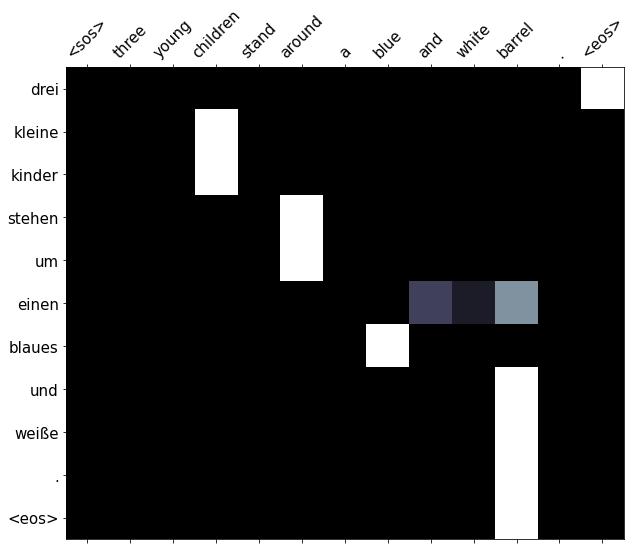

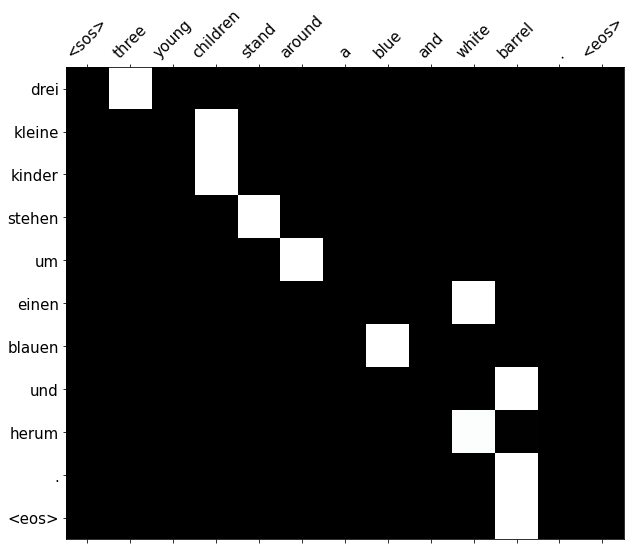

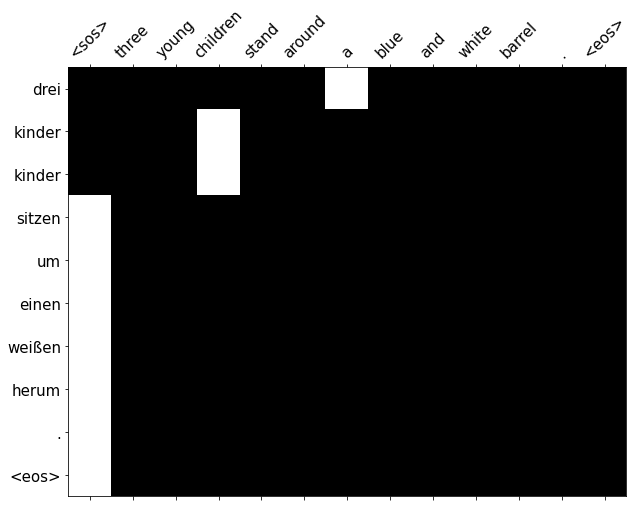

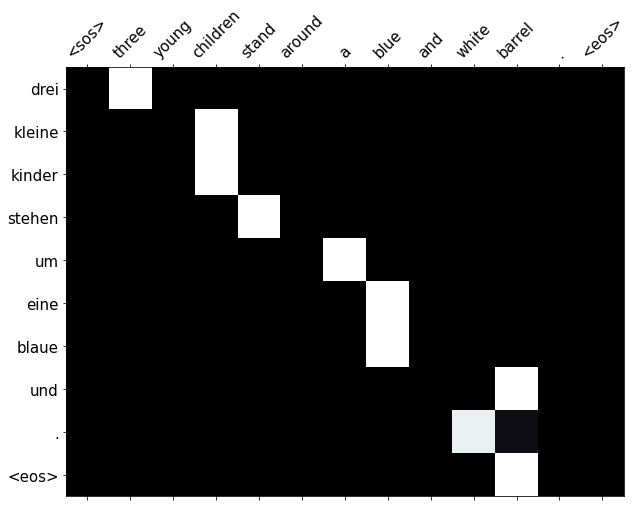

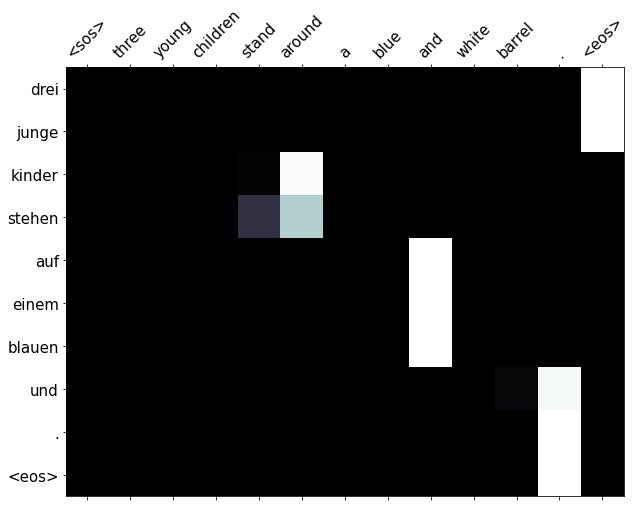

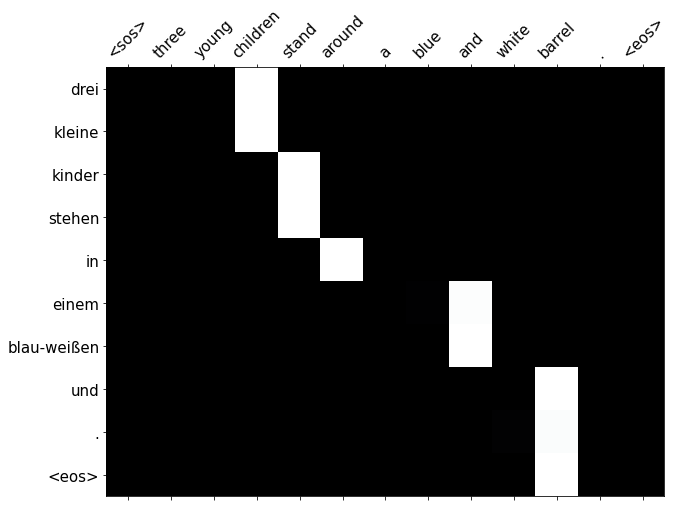

In [22]:
from Luong.validator import single_decode
from Luong.validator import display_attention

src = "three young children stand around a blue and white barrel ."
trg = "drei kleine kinder stehen um ein blau-weißes fass herum ."


print("source sentence         | ",src)
print("targe sentence          | ",trg)


for i in range(1,7):
    exec(f"src_sentence, translation{i}, atten_weights{i} = single_decode(model{i}, src, dataset, 'greedy', reverse_src=reverse_src)")
    exec(f"print('model{i} predict sentence |  '+' '.join(translation{i}))")
    
for i in range(1,7):
    exec(f"display_attention(src_sentence, translation{i}, atten_weights{i})")

The model few attend to things make sense such as word alignment, but it translates the sentence correctly to some extent.

source sentence         |  a little girl is holding a little boy on her lap .
targe sentence          |  ein kleines mädchen hält einen kleinen jungen auf ihrem schoß .
model1 predict sentence |  ein kleines mädchen hält einen kleinen jungen auf dem schoß . <eos>
model2 predict sentence |  ein kleines mädchen hält auf dem schoß auf dem schoß . <eos>
model3 predict sentence |  ein kleines mädchen hält einen kleinen jungen auf einem kleinen . <eos>
model4 predict sentence |  ein kleines mädchen hält einen kleinen jungen auf dem schoß . <eos>
model5 predict sentence |  ein kleines mädchen hält ein kleines mädchen auf dem schoß . <eos>
model6 predict sentence |  ein kleines mädchen hält einen kleinen jungen auf ihrem schoß . <eos>


/data/data_ljy/Pycharm_Project/Luong_Attention/Luong/validator.py:123: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, rotation=45)
/data/data_ljy/Pycharm_Project/Luong_Attention/Luong/validator.py:124: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks)


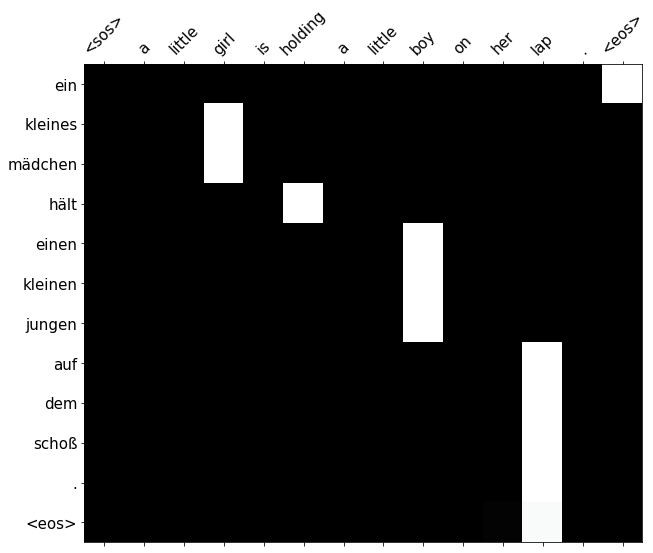

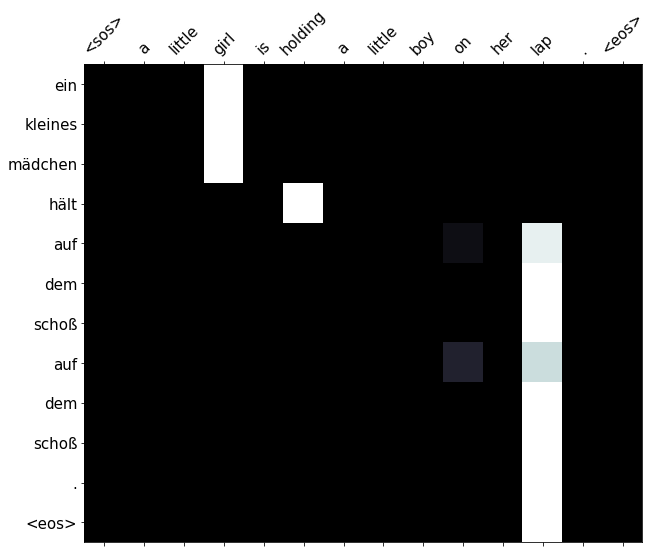

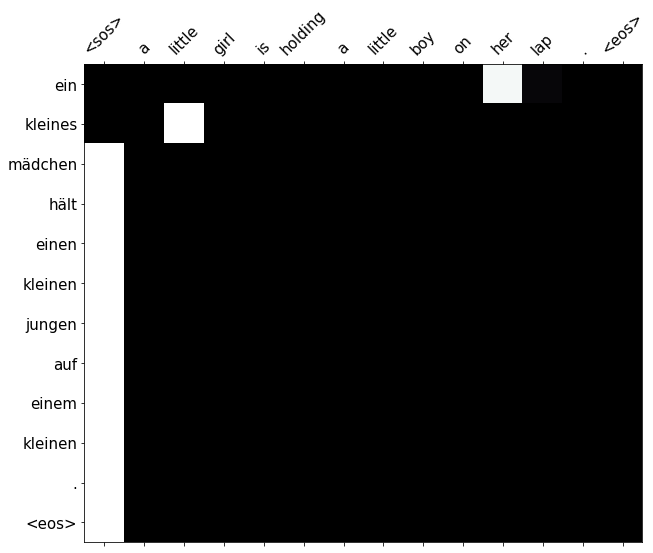

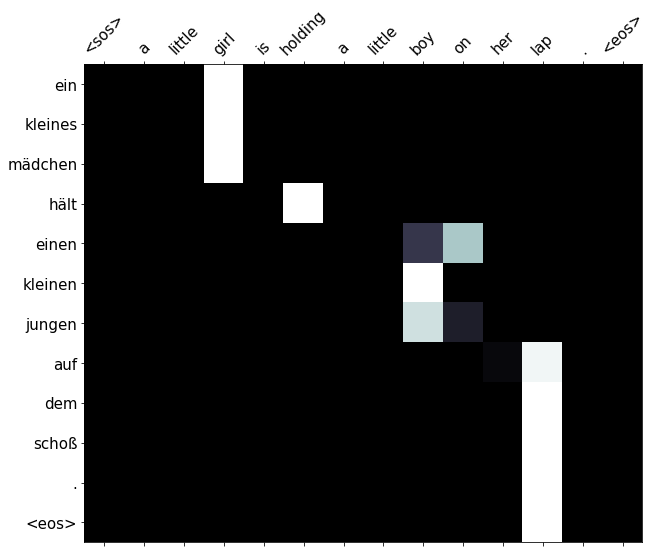

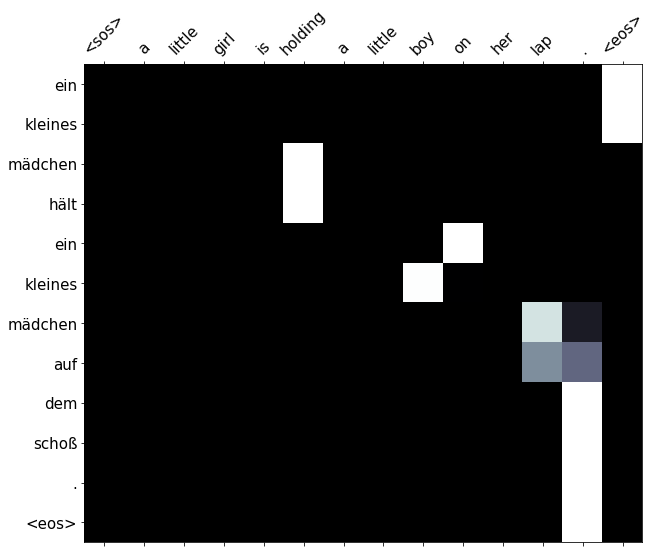

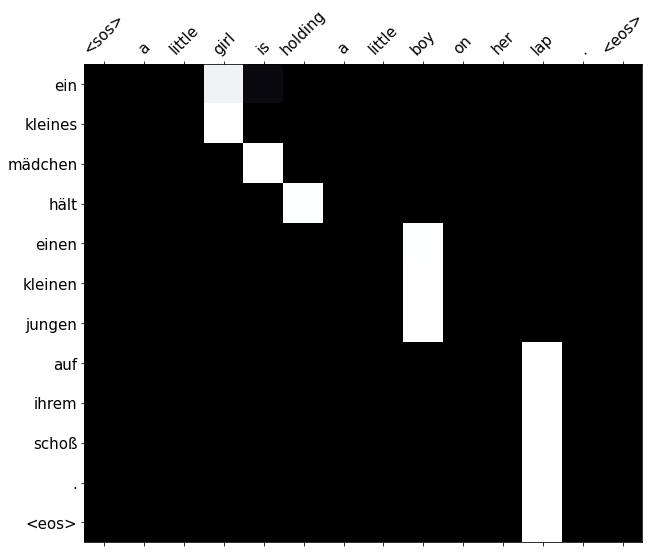

In [7]:
from Luong.validator import single_decode
from Luong.validator import display_attention

src = "a little girl is holding a little boy on her lap ."
trg = "ein kleines mädchen hält einen kleinen jungen auf ihrem schoß ."


print("source sentence         | ",src)
print("targe sentence          | ",trg)


for i in range(1,7):
    exec(f"src_sentence, translation{i}, atten_weights{i} = single_decode(model{i}, src, dataset, 'greedy', reverse_src=reverse_src)")
    exec(f"print('model{i} predict sentence |  '+' '.join(translation{i}))")
    
for i in range(1,7):
    exec(f"display_attention(src_sentence, translation{i}, atten_weights{i})")

### General Method

In [3]:
from Luong.trainer import train
import torch

clip = 5
lr = 1e-2
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# optimizer = torch.optim.SGD(model.parameters(), lr)
optimizer = torch.optim.Adam(model.parameters())

train(model, optimizer, clip, dataset, 
      num_epochs=15, mini_batch_size=128, accum_iter=1,
      print_every=100)

model.save("Luong_general04_E15.pt")

batch_size: 128
-----------------------------------------------------------------
Epoch 1
-----------------------------------------------------------------
[ 100/227 ] Loss: 5.339409... Val Loss: 5.652830... Val BLEU: 1.746509...
[ 200/227 ] Loss: 5.216557... Val Loss: 5.570998... Val BLEU: 2.225429...
[ 227/227 ] Loss: 5.128646... Val Loss: 5.453491... Val BLEU: 2.525401...
Total Epoche:  |    Time: 0m 24s
 Epoch Loss: 5.235359... Train BLEU: 2.443830...
-----------------------------------------------------------------
Epoch 2
-----------------------------------------------------------------
[ 100/227 ] Loss: 4.998170... Val Loss: 5.331376... Val BLEU: 3.324852...
[ 200/227 ] Loss: 4.699385... Val Loss: 5.136492... Val BLEU: 5.244382...
[ 227/227 ] Loss: 4.829062... Val Loss: 5.067621... Val BLEU: 5.964163...
Total Epoche:  |    Time: 0m 19s
 Epoch Loss: 4.831471... Train BLEU: 5.040517...
-----------------------------------------------------------------
Epoch 3
----------------------

We load four models for comparison

In [8]:
from Luong.models import Seq2Seq

device = "cuda"

for i in range(1,5):
    exec(f"model{i} = Seq2Seq(src_vocab_size,trg_vocab_size,src_pad_idx,trg_pad_idx,build=False).to(device)")
    exec(f"model{i}.load('Luong_general0{i}_E15.pt',device)")

In [9]:
batch_size = 128
train_iterator, val_iterator, test_iter = dataset.build_DataLoad(batch_size)

from Luong.validator import evaluate

pad_idx = dataset.srcField.vocab.__getitem__(dataset.special_tokens['pad'])
bos_idx = dataset.srcField.vocab.__getitem__(dataset.special_tokens['bos'])
eos_idx = dataset.srcField.vocab.__getitem__(dataset.special_tokens['eos'])

for i in range(1,5):
    exec(f"test_loss{i}, BLEU_score{i} = evaluate(model{i}, test_iter, pad_idx, bos_idx, eos_idx, trgField=dataset.trgField, BLEU=True)")
    exec(f"print('Modle{i} Test set cost:',test_loss{i},'  |  Test set BLEU score:',BLEU_score{i})")

Modle1 Test set cost: 3.933708667755127   |  Test set BLEU score: 24.1124852760778
Modle2 Test set cost: 3.878413438796997   |  Test set BLEU score: 25.420172641144916
Modle3 Test set cost: 3.87752103805542   |  Test set BLEU score: 25.65130379023727
Modle4 Test set cost: 4.048796653747559   |  Test set BLEU score: 22.057043699925018


source sentence         |  a group of people are climbing in cold weather .
targe sentence          |  eine gruppe klettert bei kaltem wetter .
model1 predict sentence |  eine gruppe leute klettert in einem abgedunkelten wetter . <eos>
model2 predict sentence |  eine gruppe von menschen in in einer wetter . <eos>
model3 predict sentence |  eine gruppe von menschen klettert in einem wetter . <eos>
model4 predict sentence |  eine gruppe von menschen beim klettern in . <eos>


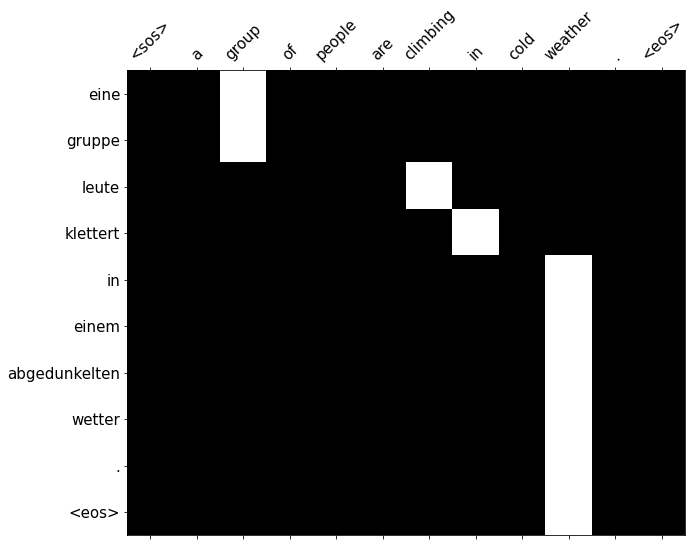

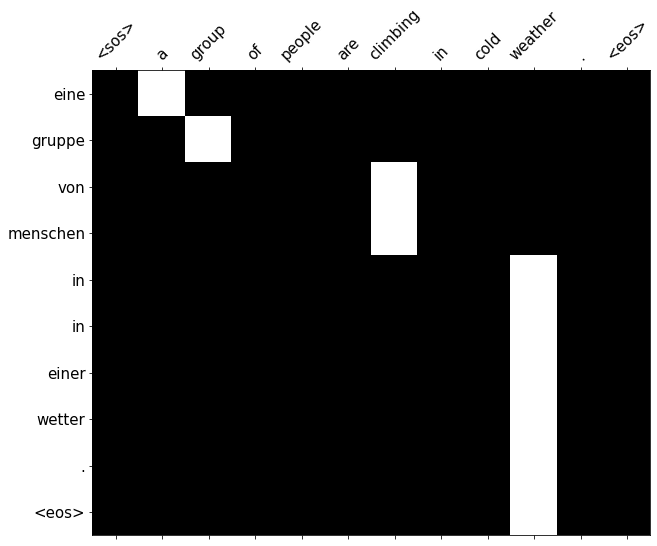

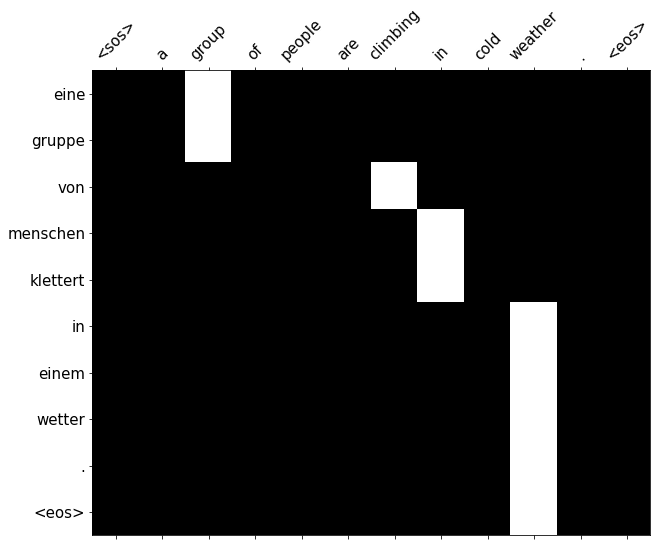

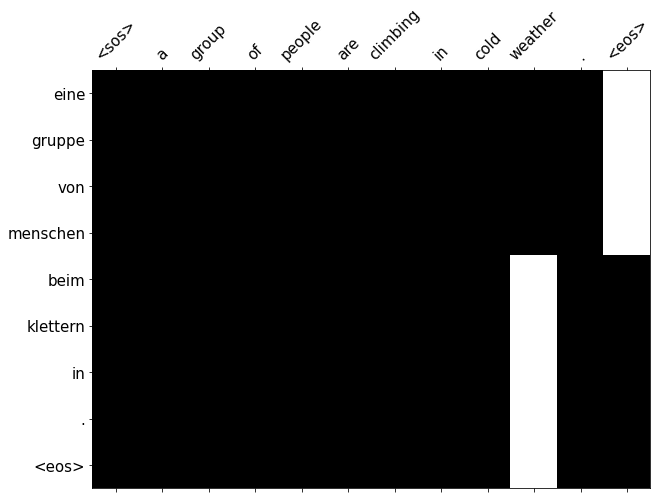

In [11]:
from Luong.validator import single_decode
from Luong.validator import display_attention

src = "a group of people are climbing in cold weather ."
trg = "eine gruppe klettert bei kaltem wetter ."


print("source sentence         | ",src)
print("targe sentence          | ",trg)


for i in range(1,5):
    exec(f"src_sentence, translation{i}, atten_weights{i} = single_decode(model{i}, src, dataset, 'greedy', reverse_src=reverse_src)")
    exec(f"print('model{i} predict sentence |  '+' '.join(translation{i}))")
    
for i in range(1,5):
    exec(f"display_attention(src_sentence, translation{i}, atten_weights{i})")

source sentence         |  a large crowd of people are standing around in a park and a few are playing instruments .
targe sentence          |  eine große menschenmenge steht in einem park herum und einige spielen auf instrumenten .
model1 predict sentence |  eine große menschenmenge steht in einem park und spielen in einem park . <eos>
model2 predict sentence |  eine große menschenmenge steht in einem park herum und eine instrumente . <eos>
model3 predict sentence |  eine große menschenmenge steht in einem park und spielen instrumente . <eos>
model4 predict sentence |  eine große menschenmenge steht in einem park und spielt auf einem kreis und spielen . <eos>


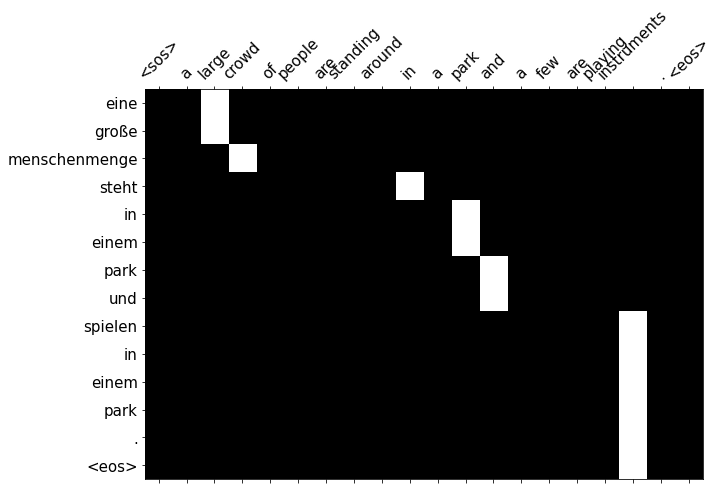

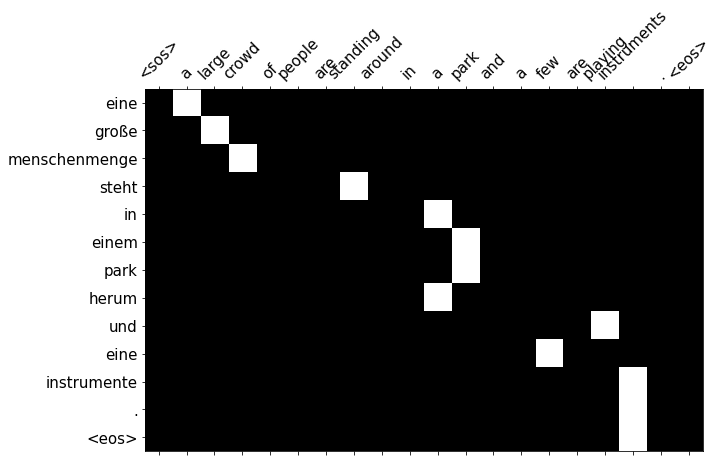

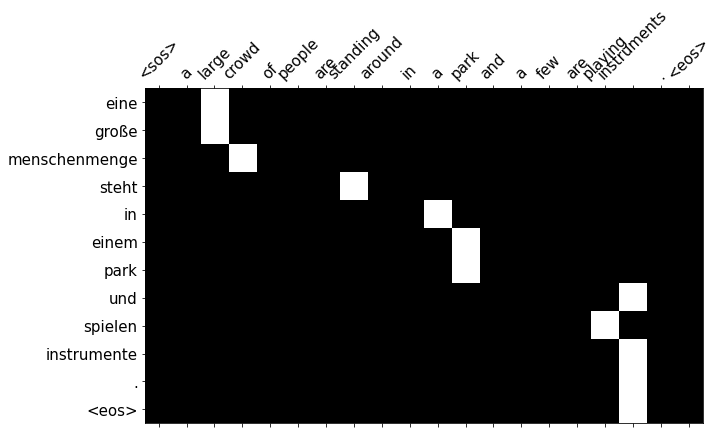

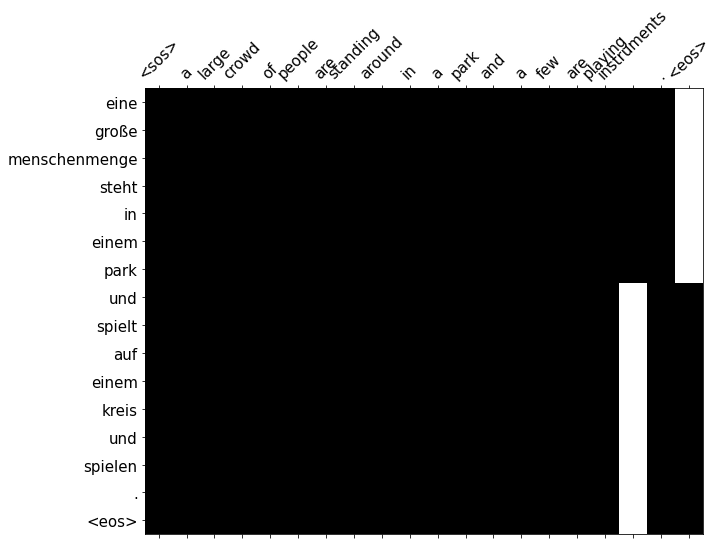

In [12]:
from Luong.validator import single_decode
from Luong.validator import display_attention

src = "a large crowd of people are standing around in a park and a few are playing instruments ."
trg = "eine große menschenmenge steht in einem park herum und einige spielen auf instrumenten ."


print("source sentence         | ",src)
print("targe sentence          | ",trg)


for i in range(1,5):
    exec(f"src_sentence, translation{i}, atten_weights{i} = single_decode(model{i}, src, dataset, 'greedy', reverse_src=reverse_src)")
    exec(f"print('model{i} predict sentence |  '+' '.join(translation{i}))")
    
for i in range(1,5):
    exec(f"display_attention(src_sentence, translation{i}, atten_weights{i})")

### Concat Method

In [3]:
from Luong.trainer import train
import torch

clip = 5
lr = 1e-2
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# optimizer = torch.optim.SGD(model.parameters(), lr)
optimizer = torch.optim.Adam(model.parameters())

train(model, optimizer, clip, dataset, 
      num_epochs=15, mini_batch_size=128, accum_iter=1,
      print_every=100)

model.save("Luong_concat02_E15.pt")

batch_size: 128
-----------------------------------------------------------------
Epoch 1
-----------------------------------------------------------------
[ 100/227 ] Loss: 5.645696... Val Loss: 5.628458... Val BLEU: 1.949646...
[ 200/227 ] Loss: 5.097995... Val Loss: 5.275041... Val BLEU: 3.440935...
[ 227/227 ] Loss: 5.267953... Val Loss: 5.132988... Val BLEU: 4.773530...
Total Epoche:  |    Time: 0m 19s
 Epoch Loss: 4.943882... Train BLEU: 4.233636...
-----------------------------------------------------------------
Epoch 2
-----------------------------------------------------------------
[ 100/227 ] Loss: 5.237400... Val Loss: 4.872891... Val BLEU: 6.781268...
[ 200/227 ] Loss: 3.881248... Val Loss: 4.648441... Val BLEU: 9.700919...
[ 227/227 ] Loss: 4.531252... Val Loss: 4.614131... Val BLEU: 10.051468...
Total Epoche:  |    Time: 0m 19s
 Epoch Loss: 4.341012... Train BLEU: 9.699173...
-----------------------------------------------------------------
Epoch 3
---------------------

In [2]:
from Luong.models import Seq2Seq

device = "cuda"

model = Seq2Seq(src_vocab_size,trg_vocab_size,src_pad_idx,trg_pad_idx,build=False).to(device)
model.load("Luong_concat01_E15.pt",device)

/home/ljy/.conda/envs/long_NLP/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.15 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


source sentence  |  a girl in white and a girl in green walk past a blue car wash station .
targe sentence   |  ein mädchen in weiß und eines in grün gehen an einer blauen autowaschanlage vorbei .
predict sentence |  ein mädchen in blau und ein blauer gekleidet geht an einem grünen vorüber in einer telefonzelle vorbei . <eos>


/data/data_ljy/Pycharm_Project/Luong_Attention/Luong/validator.py:123: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, rotation=45)
/data/data_ljy/Pycharm_Project/Luong_Attention/Luong/validator.py:124: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks)


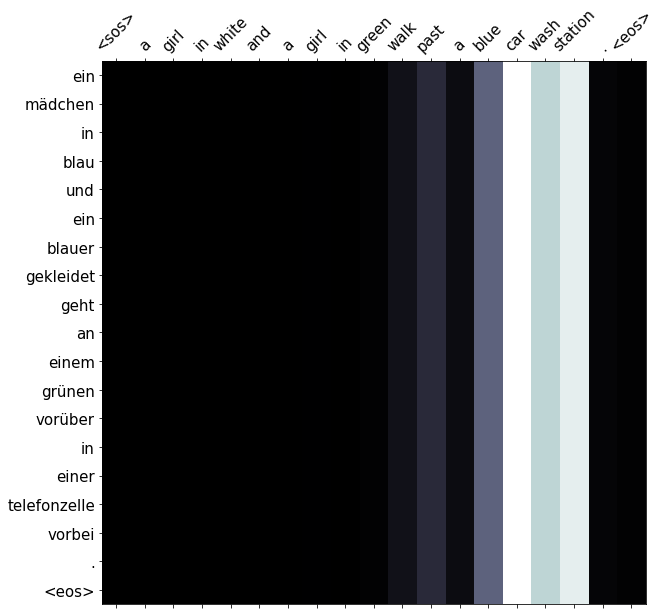

In [3]:
from Luong.validator import single_decode
from Luong.validator import display_attention

src = "a girl in white and a girl in green walk past a blue car wash station ."
trg = "ein mädchen in weiß und eines in grün gehen an einer blauen autowaschanlage vorbei ."

src_sentence, translation, atten_weights = single_decode(model, src, dataset, "greedy", reverse_src=reverse_src)

print("source sentence  | ",src)
print("targe sentence   | ",trg)
print("predict sentence |  "+' '.join(translation))

display_attention(src_sentence, translation, atten_weights)

### Multi Layer Percpetron Method


In [3]:
from Luong.trainer import train
import torch

clip = 5
lr = 1e-2
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# optimizer = torch.optim.SGD(model.parameters(), lr)
optimizer = torch.optim.Adam(model.parameters())

train(model, optimizer, clip, dataset, 
      num_epochs=15, mini_batch_size=128, accum_iter=1,
      print_every=100)

model.save("Luong_MLP04_E15.pt")

batch_size: 128
-----------------------------------------------------------------
Epoch 1
-----------------------------------------------------------------
[ 100/227 ] Loss: 5.245370... Val Loss: 5.653451... Val BLEU: 1.728397...
[ 200/227 ] Loss: 5.752860... Val Loss: 5.268235... Val BLEU: 2.798555...
[ 227/227 ] Loss: 5.202917... Val Loss: 5.098620... Val BLEU: 3.978742...
Total Epoche:  |    Time: 0m 21s
 Epoch Loss: 4.921487... Train BLEU: 3.522963...
-----------------------------------------------------------------
Epoch 2
-----------------------------------------------------------------
[ 100/227 ] Loss: 3.977043... Val Loss: 4.704380... Val BLEU: 9.249944...
[ 200/227 ] Loss: 5.172569... Val Loss: 4.308236... Val BLEU: 14.150789...
[ 227/227 ] Loss: 3.595507... Val Loss: 4.279503... Val BLEU: 14.865085...
Total Epoche:  |    Time: 0m 21s
 Epoch Loss: 4.054867... Train BLEU: 13.968386...
-----------------------------------------------------------------
Epoch 3
-------------------

In [3]:
from Luong.models import Seq2Seq

device = "cuda"

for i in range(1,5):
    exec(f"model{i} = Seq2Seq(src_vocab_size,trg_vocab_size,src_pad_idx,trg_pad_idx,build=False).to(device)")
    exec(f"model{i}.load('Luong_MLP0{i}_E15.pt',device)")

In [4]:
batch_size = 128
train_iterator, val_iterator, test_iter = dataset.build_DataLoad(batch_size)

from Luong.validator import evaluate

pad_idx = dataset.srcField.vocab.__getitem__(dataset.special_tokens['pad'])
bos_idx = dataset.srcField.vocab.__getitem__(dataset.special_tokens['bos'])
eos_idx = dataset.srcField.vocab.__getitem__(dataset.special_tokens['eos'])

for i in range(1,5):
    exec(f"test_loss{i}, BLEU_score{i} = evaluate(model{i}, test_iter, pad_idx, bos_idx, eos_idx, trgField=dataset.trgField, BLEU=True)")
    exec(f"print('Modle{i} Test set cost:',test_loss{i},'  |  Test set BLEU score:',BLEU_score{i})")

Modle1 Test set cost: 3.9980766773223877   |  Test set BLEU score: 30.121716856956482
Modle2 Test set cost: 3.959221363067627   |  Test set BLEU score: 30.417088856462676
Modle3 Test set cost: 3.9999465942382812   |  Test set BLEU score: 30.0021231174469
Modle4 Test set cost: 3.966646194458008   |  Test set BLEU score: 29.492560029029846


source sentence         |  a little girl is holding a little boy on her lap .
targe sentence          |  ein kleines mädchen hält einen kleinen jungen auf ihrem schoß .
model1 predict sentence |  ein kleines mädchen hält einen kleinen jungen auf dem schoß . <eos>
model2 predict sentence |  ein kleines mädchen hält auf dem schoß auf dem schoß . <eos>
model3 predict sentence |  ein kleines mädchen hält einen kleinen jungen auf dem schoß . <eos>
model4 predict sentence |  ein kleines mädchen hält einen kleinen jungen auf dem schoß . <eos>


/data/data_ljy/Pycharm_Project/Luong_Attention/Luong/validator.py:123: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, rotation=45)
/data/data_ljy/Pycharm_Project/Luong_Attention/Luong/validator.py:124: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks)


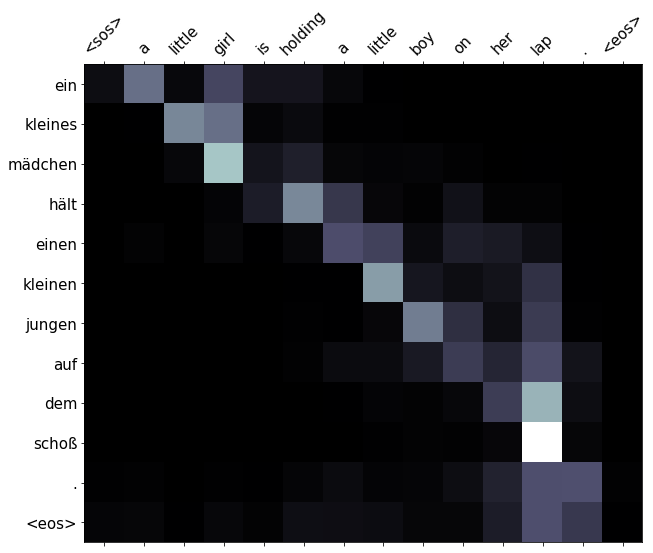

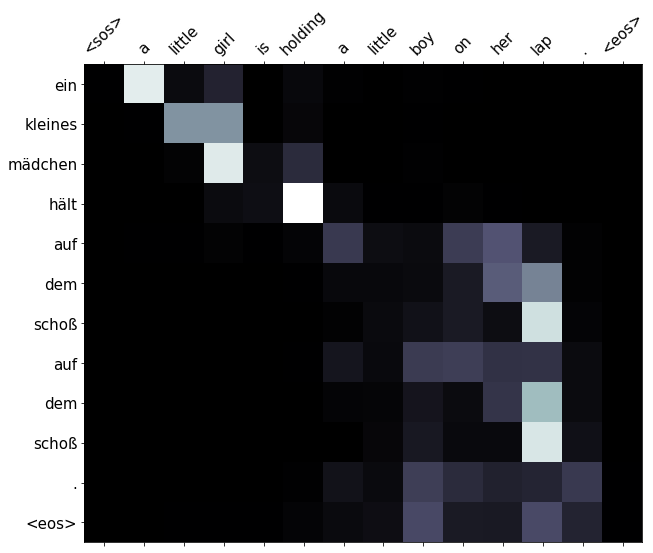

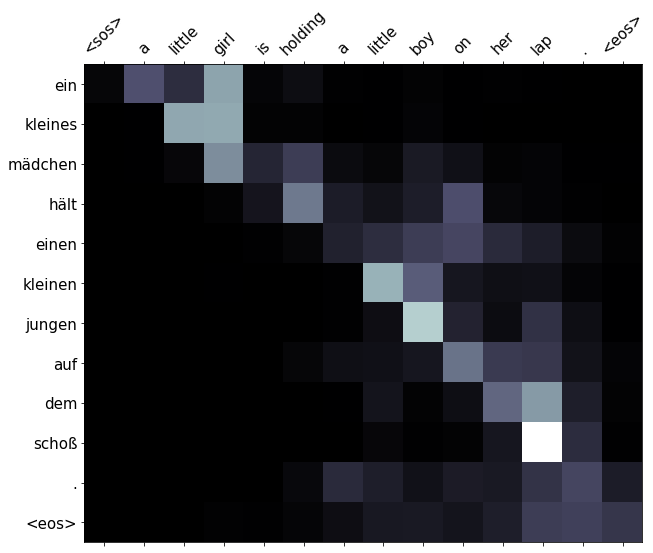

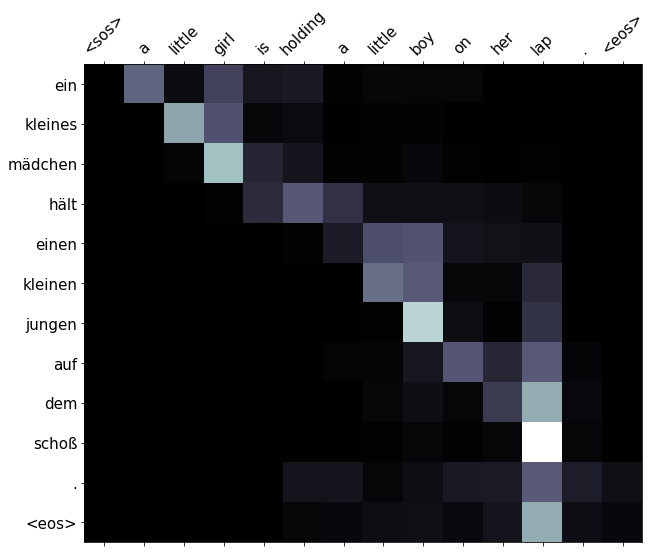

In [6]:
from Luong.validator import single_decode
from Luong.validator import display_attention

src = "a little girl is holding a little boy on her lap ."
trg = "ein kleines mädchen hält einen kleinen jungen auf ihrem schoß ."


print("source sentence         | ",src)
print("targe sentence          | ",trg)


for i in range(1,5):
    exec(f"src_sentence, translation{i}, atten_weights{i} = single_decode(model{i}, src, dataset, 'greedy', reverse_src=reverse_src)")
    exec(f"print('model{i} predict sentence |  '+' '.join(translation{i}))")
    
for i in range(1,5):
    exec(f"display_attention(src_sentence, translation{i}, atten_weights{i})")

source sentence         |  a girl in white and a girl in green walk past a blue car wash station .
targe sentence          |  ein mädchen in weiß und eines in grün gehen an einer blauen autowaschanlage vorbei .
model1 predict sentence |  ein mädchen in weiß und ein mädchen in grün mädchen gehen an einem blauen auto vorbei . <eos>
model2 predict sentence |  ein mädchen in weiß und ein mädchen mädchen gehen an einem blauen auto vorbei . <eos>
model3 predict sentence |  ein mädchen in weißem und mädchen in grünen kleidung geht an einem blauen auto vorbei . <eos>
model4 predict sentence |  ein mädchen in weiß und ein mädchen in grünen grünen gehen an einer blauen auto vorbei . <eos>


/data/data_ljy/Pycharm_Project/Luong_Attention/Luong/validator.py:123: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, rotation=45)
/data/data_ljy/Pycharm_Project/Luong_Attention/Luong/validator.py:124: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks)


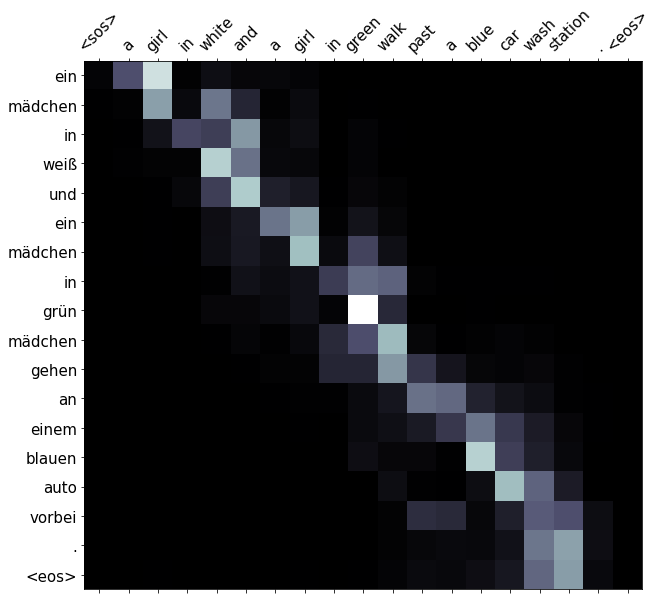

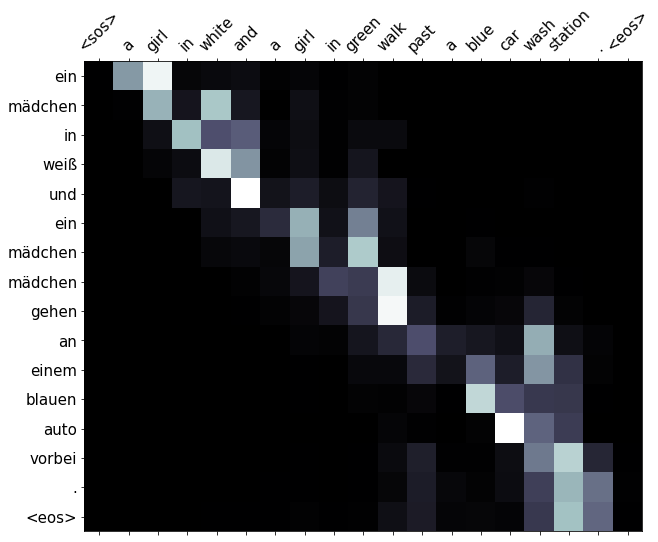

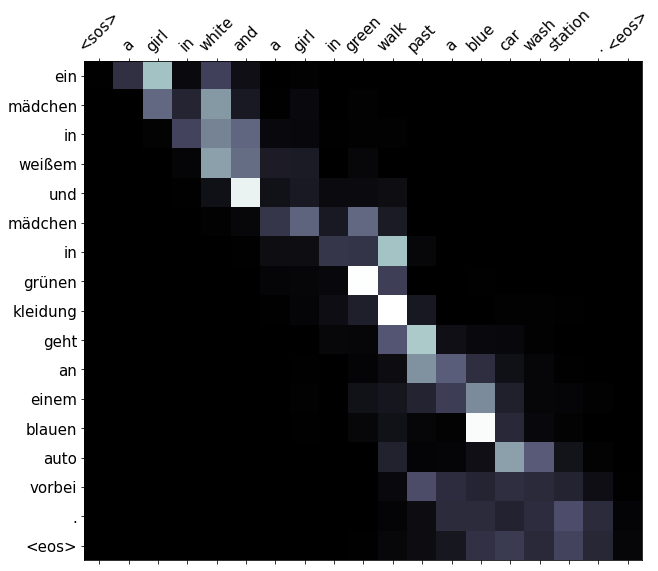

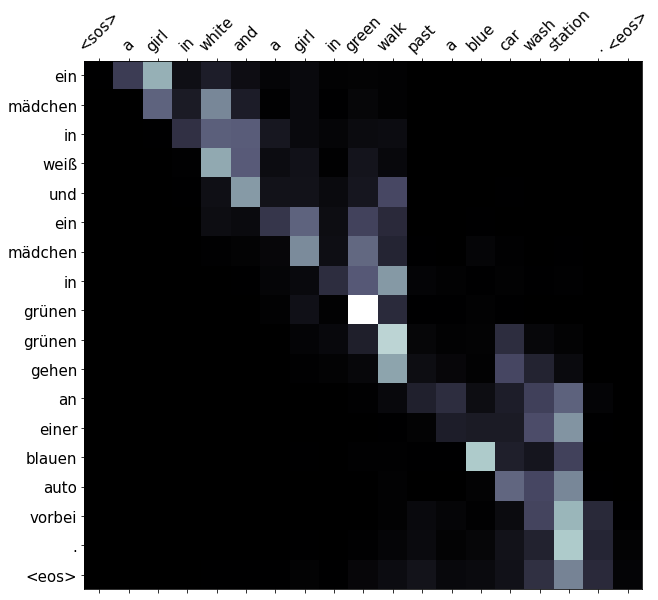

In [5]:
from Luong.validator import single_decode
from Luong.validator import display_attention

src = "a girl in white and a girl in green walk past a blue car wash station ."
trg = "ein mädchen in weiß und eines in grün gehen an einer blauen autowaschanlage vorbei ."


print("source sentence         | ",src)
print("targe sentence          | ",trg)


for i in range(1,5):
    exec(f"src_sentence, translation{i}, atten_weights{i} = single_decode(model{i}, src, dataset, 'greedy', reverse_src=reverse_src)")
    exec(f"print('model{i} predict sentence |  '+' '.join(translation{i}))")
    
for i in range(1,5):
    exec(f"display_attention(src_sentence, translation{i}, atten_weights{i})")

## Multi-Layer RNN
### 2-layer RNN

In [2]:
from Luong.models import Seq2Seq

device = "cuda"

model = Seq2Seq(src_vocab_size,trg_vocab_size,src_pad_idx,trg_pad_idx,build=False).to(device)
model.load("Luong_layer2_MLP01_E15.pt",device)

In [3]:
batch_size = 128
train_iterator, val_iterator, test_iter = dataset.build_DataLoad(batch_size)

from Luong.validator import evaluate

pad_idx = dataset.srcField.vocab.__getitem__(dataset.special_tokens['pad'])
bos_idx = dataset.srcField.vocab.__getitem__(dataset.special_tokens['bos'])
eos_idx = dataset.srcField.vocab.__getitem__(dataset.special_tokens['eos'])

test_loss, BLEU_score = evaluate(model, test_iter,
                                 pad_idx, bos_idx, eos_idx,
                                 trgField=dataset.trgField, BLEU=True)

print("Test set cost:",test_loss,"  |  Test set BLEU score:",BLEU_score)

Test set cost: 3.90775728225708   |  Test set BLEU score: 28.639711206247142


source sentence  |  a girl in white and a girl in green walk past a blue car wash station .
targe sentence   |  ein mädchen in weiß und eines in grün gehen an einer blauen autowaschanlage vorbei .
predict sentence |  ein mädchen in weiß und ein mädchen in grünen kleidung gehen an einem blauen auto vorbei . <eos>


/data/data_ljy/Pycharm_Project/Luong_Attention/Luong/validator.py:123: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, rotation=45)
/data/data_ljy/Pycharm_Project/Luong_Attention/Luong/validator.py:124: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks)


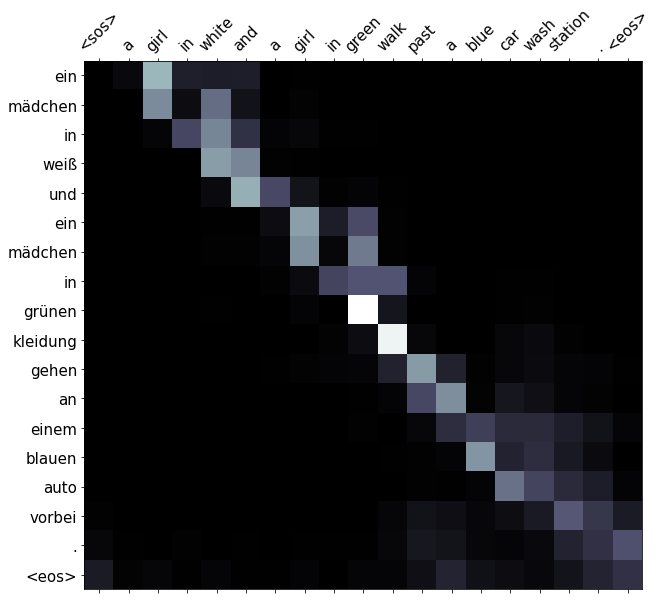

In [4]:
from Luong.validator import single_decode
from Luong.validator import display_attention

src = "a girl in white and a girl in green walk past a blue car wash station ."
trg = "ein mädchen in weiß und eines in grün gehen an einer blauen autowaschanlage vorbei ."

src_sentence, translation, atten_weights = single_decode(model, src, dataset, "greedy", reverse_src=reverse_src)

print("source sentence  | ",src)
print("targe sentence   | ",trg)
print("predict sentence |  "+' '.join(translation))

display_attention(src_sentence, translation, atten_weights)

### 3-layer RNN

In [10]:
from Luong.models import Seq2Seq

device = "cuda"

model = Seq2Seq(src_vocab_size,trg_vocab_size,src_pad_idx,trg_pad_idx,build=False).to(device)
model.load("Luong_layer3_MLP01_E35.pt",device)

In [11]:
batch_size = 128
train_iterator, val_iterator, test_iter = dataset.build_DataLoad(batch_size)

from Luong.validator import evaluate

pad_idx = dataset.srcField.vocab.__getitem__(dataset.special_tokens['pad'])
bos_idx = dataset.srcField.vocab.__getitem__(dataset.special_tokens['bos'])
eos_idx = dataset.srcField.vocab.__getitem__(dataset.special_tokens['eos'])

test_loss, BLEU_score = evaluate(model, test_iter,
                                 pad_idx, bos_idx, eos_idx,
                                 trgField=dataset.trgField, BLEU=True)

print("Test set cost:",test_loss,"  |  Test set BLEU score:",BLEU_score)

Test set cost: 4.280118465423584   |  Test set BLEU score: 24.74445402622223


source sentence  |  a girl in white and a girl in green walk past a blue car wash station .
targe sentence   |  ein mädchen in weiß und eines in grün gehen an einer blauen autowaschanlage vorbei .
predict sentence |  ein weiß in weiß und ein mädchen in grün gehen an einem laden vorbei vorbei vorbei . <eos>


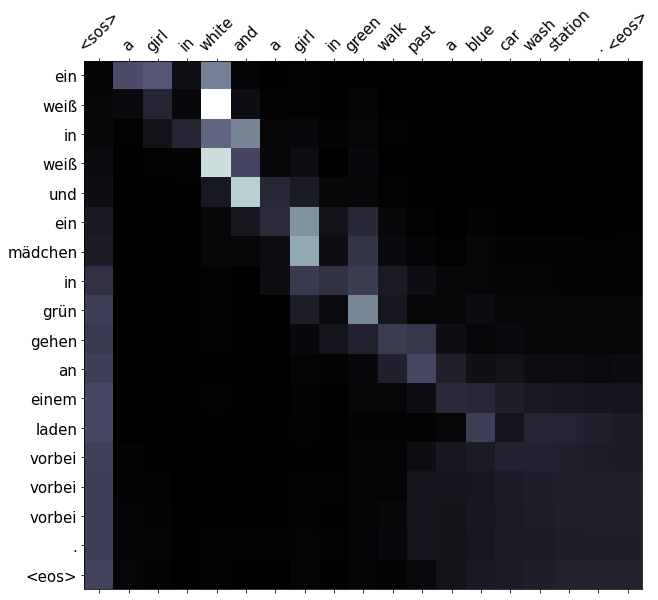

In [12]:
from Luong.validator import single_decode
from Luong.validator import display_attention

src = "a girl in white and a girl in green walk past a blue car wash station ."
trg = "ein mädchen in weiß und eines in grün gehen an einer blauen autowaschanlage vorbei ."

src_sentence, translation, atten_weights = single_decode(model, src, dataset, "greedy", reverse_src=reverse_src)

print("source sentence  | ",src)
print("targe sentence   | ",trg)
print("predict sentence |  "+' '.join(translation))

display_attention(src_sentence, translation, atten_weights)

## Reverse the order of source sentence

In [2]:
from Luong.models import Seq2Seq

device = "cuda"

model = Seq2Seq(src_vocab_size,trg_vocab_size,src_pad_idx,trg_pad_idx,build=False).to(device)
model.load("Luong_reverse_MLP01_E15.pt",device)

/home/ljy/.conda/envs/long_NLP/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.15 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [3]:
batch_size = 128
train_iterator, val_iterator, test_iter = dataset.build_DataLoad(batch_size)

from Luong.validator import evaluate

pad_idx = dataset.srcField.vocab.__getitem__(dataset.special_tokens['pad'])
bos_idx = dataset.srcField.vocab.__getitem__(dataset.special_tokens['bos'])
eos_idx = dataset.srcField.vocab.__getitem__(dataset.special_tokens['eos'])

test_loss, BLEU_score = evaluate(model, test_iter,
                                 pad_idx, bos_idx, eos_idx,
                                 trgField=dataset.trgField, BLEU=True)

print("Test set cost:",test_loss,"  |  Test set BLEU score:",BLEU_score)

Test set cost: 3.903390645980835   |  Test set BLEU score: 31.008873188974672


source sentence  |  a girl in white and a girl in green walk past a blue car wash station .
targe sentence   |  ein mädchen in weiß und eines in grün gehen an einer blauen autowaschanlage vorbei .
predict sentence |  ein weiß gekleidetes mädchen und ein mädchen in grün gehen an einer blauen befahrenen vorbei . <eos>


/data/data_ljy/Pycharm_Project/Luong_Attention/Luong/validator.py:123: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, rotation=45)
/data/data_ljy/Pycharm_Project/Luong_Attention/Luong/validator.py:124: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_ticks)


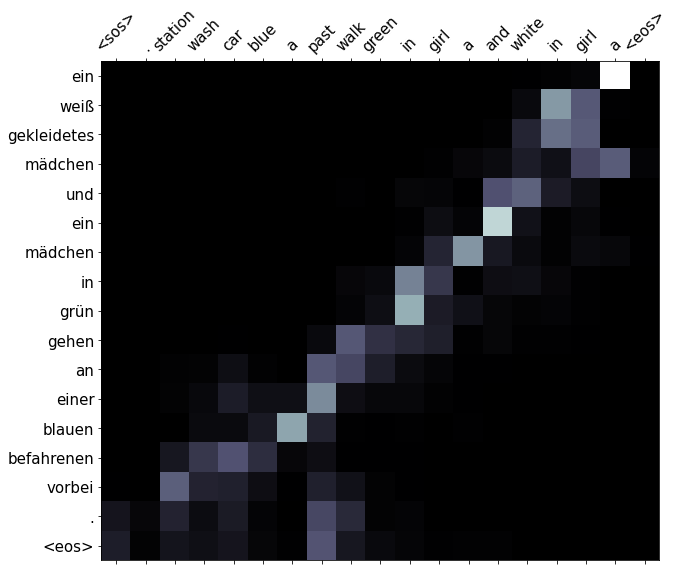

In [4]:
from Luong.validator import single_decode
from Luong.validator import display_attention

src = "a girl in white and a girl in green walk past a blue car wash station ."
trg = "ein mädchen in weiß und eines in grün gehen an einer blauen autowaschanlage vorbei ."

src_sentence, translation, atten_weights = single_decode(model, src, dataset, "greedy", reverse_src=reverse_src)

print("source sentence  | ",src)
print("targe sentence   | ",trg)
print("predict sentence |  "+' '.join(translation))

display_attention(src_sentence, translation, atten_weights)

source sentence  |  a female playing a song on her violin .
targe sentence   |  eine frau spielt ein lied auf ihrer geige .
predict sentence |  eine frau spielt auf dem violine . <eos>


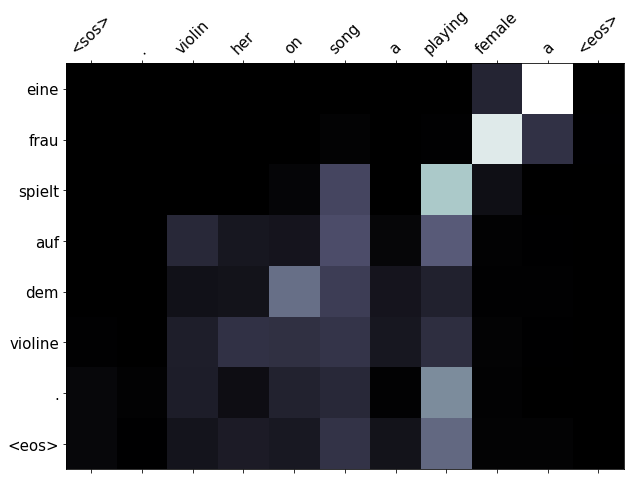

In [5]:
from Luong.validator import single_decode
from Luong.validator import display_attention

src = "a female playing a song on her violin ."
trg = "eine frau spielt ein lied auf ihrer geige ."

src_sentence, translation, atten_weights = single_decode(model, src, dataset, "greedy", reverse_src=reverse_src)

print("source sentence  | ",src)
print("targe sentence   | ",trg)
print("predict sentence |  "+' '.join(translation))

display_attention(src_sentence, translation, atten_weights)